In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py

In [7]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mf, mc, opt_chkfile = run_casci(scf_checkfile, ncas = 3, nroots=4)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.86151422722833  <S^2> = 2.4424907e-15  2S+1 = 1
LDA
converged SCF energy = -2.83456474290722  <S^2> = 3.1086245e-15  2S+1 = 1
CASCI nelecas up/down (1, 1)

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state   0  E = -2.86838486726576  E(CI) = -2.86838486726576  S^2 = 0.0000000
CASCI state   1  E = -1.96435654140743  E(CI) = -1.96435654140743  S^2 = 2.0000000
CASCI state   2  E = -1.82242033881664  E(CI) = -1.82242033881664  S^2 = 0.0000000
CASCI state   3  E = -1.55439202079245  E(CI) = -1.55439202079245  S^2 = 2.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mo_coeff', 'ncas', 'nelecas']>


In [16]:
#ABVMC
#
#
import importlib, recipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, bosonenergy
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, bosonenergy] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

import concurrent
from recipes import DMC, VMC
nconfig = 1000
nblocks = 100
nsteps_per_block = 4
dt_discard = 10
reblock_size = 10
ncore = 16

#Timestep error tests
t = [1, 0.3, 0.1, 0.01, 0.001]
e_t_abvmc = []
e_t_abvmc_err = []
ab_e_dict = {}
for dt in t:
    for fname in ['abvmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
        bosonrecipes.ABVMC(scf_checkfile, "abvmc.hdf5", 
              ci_checkfile = ci_checkfile,
              verbose=True, 
              tstep=dt, 
              nconfig=1000,
              nblocks=1000,
              nsteps_per_block=20,
             )
    with h5py.File("abvmc.hdf5") as f:
        etot_t = f['energytotal'][...] 
    ab_e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



Will optimize:  dict_keys(['wf2acoeff', 'wf2bcoeff'])
Using spherical guess
--

KeyboardInterrupt: 

Text(0, 0.5, 'Energy (Ha)')

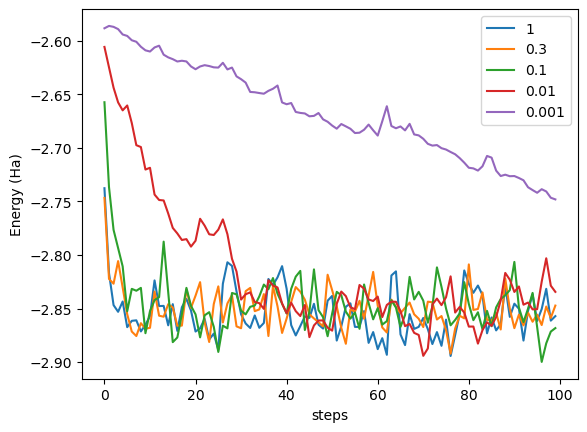

In [8]:
for i in t:
    plt.plot(ab_e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

In [5]:
#VMC
#

from recipes import DMC, VMC

for fname in ['vmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

#Timestep error tests
t = [1, 0.3, 0.1, 0.01, 0.001]
e_t_abvmc = []
e_t_abvmc_err = []
e_dict = {}
for dt in t:
    for fname in ['vmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    VMC(scf_checkfile, "vmc.hdf5", verbose=True, 
        tstep=dt, 
        nconfig=nconfig,     
        nblocks=nblocks,
        nsteps_per_block=nsteps_per_block,
       )
    with h5py.File("vmc.hdf5") as f:
        etot_t = f['energytotal'][...] 
    e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

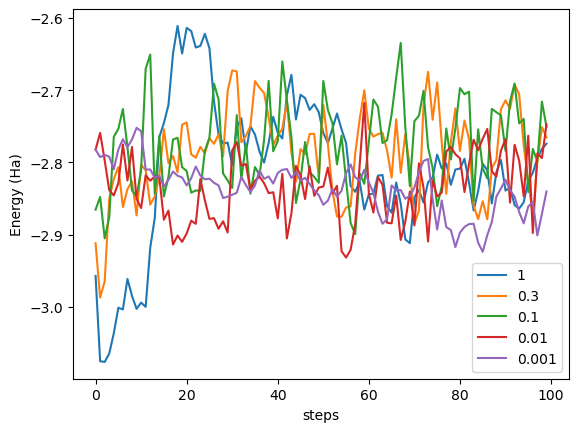

In [6]:
for i in t:
    plt.plot(e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

In [46]:
#pyqmc VMC
#
#
import pyqmc
print(pyqmc.__file__)

#Timestep error tests
t = [1, 0.3, 0.1, 0.01]
e_t_vmc_base = []
e_t_vmc_base_err = []
e_dict_base = {}
for dt in t:
    for fname in ['vmc-base.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    dt_steps = int(nblocks*nsteps_per_block*tstep/dt)
    dt_steps = 100 if dt_steps < 1000 else dt_steps
    dt_steps = 200 if dt_steps > 2000 else dt_steps 
    dt_discard = int(dt_steps/2)
    print(dt_steps, dt_discard)
    pyqmc.recipes.VMC("scf.hdf5", "vmc-base.hdf5", verbose=True, 
                      nsteps =dt_steps, 
                      tstep=dt, 
                      nconfig=nconfig,     
                      nblocks=nblocks,
                      nsteps_per_block=nsteps_per_block)
    with h5py.File("vmc-base.hdf5") as f:
        etot_t = f['energytotal'][...] 
    e_dict_base[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_vmc_base.append(e_m)
        e_t_vmc_base_err.append(e_d)



/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyqmc/__init__.py
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

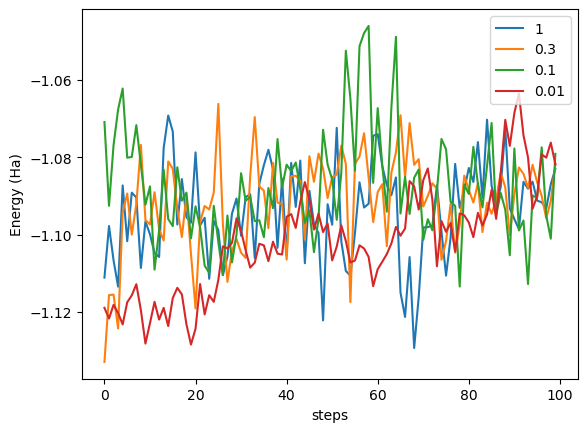

In [47]:
for i in t:
    plt.plot(e_dict_base[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')